Data Pre-processing

In [1]:
import pandas as pd


df = pd.read_csv("/content/train.tsv", sep='\t')
df.head()


,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [2]:
df = df.drop_duplicates(subset=['SentenceId'], keep='first')

df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
63,64,2,"This quiet , introspective and entertaining in...",4
81,82,3,"Even fans of Ismail Merchant 's work , I suspe...",1
116,117,4,A positively thrilling combination of ethnogra...,3
156,157,5,Aggressive self-glorification and a manipulati...,1


<Axes: xlabel='Sentiment'>

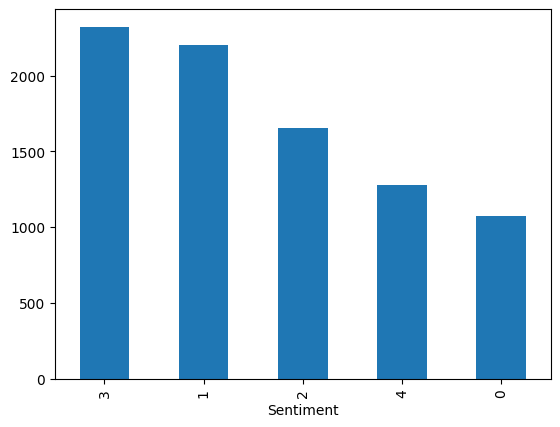

In [3]:
df['Sentiment'].value_counts().plot(kind='bar')

#0 - negative, 1 - somewhat negative, 2 - neutral, 3 - somewhat positive, 4 - positive#


We will be tokenizing this text to create two input tensors; our input IDs, and attention mask.

We will contain our tensors within two numpy arrays, which will be of dimensions len(df) * 512 - the 512 is the sequence length of our tokenized sequences for BERT, and len(df) the number of samples in our dataset.

In [4]:
import numpy as np

seq_len = 512
num_samples = len(df)

num_samples, seq_len

(8529, 512)

Now we can begin tokenizing with a BertTokenizer, like so:

In [5]:
from transformers import BertTokenizer

# initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

# tokenize - this time returning Numpy tensors
seq_len = 128  # Set sequence length to 128
tokens = tokenizer(df['Phrase'].tolist(), max_length=seq_len, truncation=True,
                   padding='max_length', add_special_tokens=True,
                   return_tensors='np')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Which returns us three numpy arrays - input_ids, token_type_ids, and attention_mask.

In [6]:
tokens.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [7]:
tokens['input_ids'][:10]

array([[ 101,  138, 1326, ...,    0,    0,    0],
       [ 101, 1188, 3589, ...,    0,    0,    0],
       [ 101, 2431, 3899, ...,    0,    0,    0],
       ...,
       [ 101, 1109,  146, ...,    0,    0,    0],
       [ 101, 1252, 1122, ...,    0,    0,    0],
       [ 101, 1192, 1180, ...,    0,    0,    0]])

In [8]:
tokens['attention_mask'][:10]

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

And now we save them to file as Numpy binary files:

In [9]:
with open('movie-xids.npy', 'wb') as f:
    np.save(f, tokens['input_ids'])
with open('movie-xmask.npy', 'wb') as f:
    np.save(f, tokens['attention_mask'])

Now that we have them on file, we can delete the in-memory arrays to free up memory.

In [10]:
del tokens

Our input tensors are prepared, but we haven't touched our target data yet. So, let's move onto that.

Presently our target data is a set of integer values (representing sentiment classes) in the Sentiment column of our dataframe df. We need to extract these values and one-hot encode them into another numpy array, which will have the dimensions len(df) * number of label classes. Again, we will initialize a numpy zero array beforehand, but we won't populate it row by row - we will use some fancy indexing techniques instead.

In [11]:
# first extract sentiment column
arr = df['Sentiment'].values

In [12]:
# we then initialize the zero array
labels = np.zeros((num_samples, arr.max()+1))
labels.shape

(8529, 5)

We are able to use arr.max()+1 to define our second dimension here because we have the values [0, 1, 2, 3, 4] in our Sentiment column, there are five unique labels which means we need our labels array to have five columns (one for each) - arr.max() = 4, so we do 4 + 1 to get our required value of 5.

Now we use the current values in our arr of [0, 1, 2, 3, 4] to place 1 values in the correct positions of our presently zeros-only array:

In [13]:
labels[np.arange(num_samples), arr] = 1

labels

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.]])

And there is our one-hot encoded labels array. Just like before, we save this to file as a Numpy binary file.

In [14]:
with open('movie-labels.npy', 'wb') as f:
    np.save(f, labels)

Input Pipeline

In [15]:
import numpy as np

with open('movie-xids.npy', 'rb') as f:
    Xids = np.load(f, allow_pickle=True)
with open('movie-xmask.npy', 'rb') as f:
    Xmask = np.load(f, allow_pickle=True)
with open('movie-labels.npy', 'rb') as f:
    labels = np.load(f, allow_pickle=True)

We can take these three arrays and create a TF dataset object with them using from_tensor_slices like so:

In [16]:
import tensorflow as tf

dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmask, labels))

dataset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(128,), dtype=tf.int64, name=None), TensorSpec(shape=(128,), dtype=tf.int64, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

Each sample in our dataset is a tuple containing a single Xids, Xmask, and labels tensor. However, when feeding data into our model we need a two-item tuple in the format (<inputs>, <outputs>). Now, we have two tensors for our inputs - so, what we do is enter our <inputs> tensor as a dictionary:

{
    'input_ids': <input_id_tensor>,
    'attention_mask': <mask_tensor>
}
To rearrange the dataset format we can map a function that modifies the format like so:

In [17]:
def map_func(input_ids, masks, labels):
    # we convert our three-item tuple into a two-item tuple where the input item is a dictionary
    return {'input_ids': input_ids, 'attention_mask': masks}, labels

# then we use the dataset map method to apply this transformation
dataset = dataset.map(map_func)

dataset.take(1)

<_TakeDataset element_spec=({'input_ids': TensorSpec(shape=(128,), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(128,), dtype=tf.int64, name=None)}, TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

Now we can see that our dataset sample format has been changed. Next, we need to shuffle our data, and batch it. We will take batch sizes of 16 and drop any samples that don't fit evenly into chunks of 16.

In [18]:
batch_size = 16

dataset = dataset.shuffle(10000).batch(batch_size, drop_remainder=True)

dataset.take(1)

<_TakeDataset element_spec=({'input_ids': TensorSpec(shape=(16, 128), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(16, 128), dtype=tf.int64, name=None)}, TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))>

Now our dataset samples are organized into batches of 16. The final step is to split our data into training and validation sets. For this we use the take and skip methods, creating and 90-10 split.

In [19]:
split = 0.9

# we need to calculate how many batches must be taken to create 90% training set
size = int((Xids.shape[0] / batch_size) * split)

size

479

In [20]:
train_ds = dataset.take(size)
val_ds = dataset.skip(size)

# free up memory
del dataset


Our two datasets are fully prepared for our model inputs. Now, we can save both to file using tf.data.experimental.save.

In [21]:
tf.data.experimental.save(train_ds, 'train')
tf.data.experimental.save(val_ds, 'val')

Instructions for updating:
Use `tf.data.Dataset.save(...)` instead.


In the next notebook we will be loading these files using tf.data.experimental.load. Which requires us to define the tensor element_spec - which describes the tensor shape. To find our dataset element spec we can write:

In [22]:
train_ds.element_spec

({'input_ids': TensorSpec(shape=(16, 128), dtype=tf.int64, name=None),
  'attention_mask': TensorSpec(shape=(16, 128), dtype=tf.int64, name=None)},
 TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))

In [23]:
val_ds.element_spec == train_ds.element_spec

True

We will be using this tuple when loading our data in the next notebook.

In [24]:
ds = tf.data.experimental.load('train', element_spec=train_ds.element_spec)

Instructions for updating:
Use `tf.data.Dataset.load(...)` instead.


Build and Train
Now we're ready to begin building our sentiment classifier and begin training. We will be building out what is essentially a frame around Bert, that will allow us to perform language classification. First, we can initialize the Bert model, which we will load as a pretrained model from transformers.

In [25]:
from transformers import TFAutoModel

bert = TFAutoModel.from_pretrained('bert-base-cased')

# we can view the model using the summary method
bert.summary()

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
Total params: 108310272 (413.17 MB)
Trainable params: 108310272 (413.17 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Now we need to define the frame around Bert, we need:

Two input layers (one for input IDs and one for attention mask).

A post-bert dropout layer to reduce the likelihood of overfitting and improve generalization.

Max pooling layer to convert the 3D tensors output by Bert to 2D.

Final output activations using softmax for outputting categorical probabilities.

In [26]:
import tensorflow as tf

# two input layers, we ensure layer name variables match to dictionary keys in TF dataset
input_ids = tf.keras.layers.Input(shape=(128,), name='input_ids', dtype='int32')  # Change 512 to 128
mask = tf.keras.layers.Input(shape=(128,), name='attention_mask', dtype='int32')  # Change 512 to 128

# we access the transformer model within our bert object using the bert attribute (eg bert.bert instead of bert)
embeddings = bert.bert(input_ids, attention_mask=mask)[1]  # access final activations (alread max-pooled) [1]
# convert bert embeddings into 5 output classes
embeddings = bert.bert(input_ids, attention_mask=mask)[1]
x = tf.keras.layers.Dense(1024, activation='relu')(embeddings)
y = tf.keras.layers.Dense(5, activation='softmax', name='outputs')(x)


We can now define our model, specifying input and output layers. Finally, we can freeze the Bert layer because Bert is already highly trained, and contains a huge number of parameters so will take a very long time to train further. Nonetheless, if you'd like to train Bert too, there is nothing wrong with doing so.

In [27]:
# initialize model
model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

# (optional) freeze bert layer
#model.layers[2].trainable = False

# print out model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 128)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                                  
 bert (TFBertMainLayer)      TFBaseModelOutputWithPooli   1083102   ['input_ids[0][0]',           
                             ngAndCrossAttentions(last_   72         'attention_mask[0][0]']      
                             hidden_state=(None, 128, 7                                       

Our model architecture is now setup, and we can initialize our training parameters like so:

In [28]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

Now all we need to do is train our model. For this, we need to load in our training and validation datasets - which also requires our dataset element specs to be defined.

In [29]:
element_spec = ({'input_ids': tf.TensorSpec(shape=(16, 128), dtype=tf.int64, name=None),
                 'attention_mask': tf.TensorSpec(shape=(16, 128), dtype=tf.int64, name=None)},
                tf.TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))

# load the training and validation sets
train_ds = tf.data.experimental.load('train', element_spec=element_spec)
val_ds = tf.data.experimental.load('val', element_spec=element_spec)

# view the input format
train_ds.take(1)

<_TakeDataset element_spec=({'input_ids': TensorSpec(shape=(16, 128), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(16, 128), dtype=tf.int64, name=None)}, TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))>

And now we train our model as usual.

In [30]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=2
)

Epoch 1/2
479/479 [==============================] - 11971s 25s/step - loss: 1.2668 - accuracy: 0.4370 - val_loss: 0.9763 - val_accuracy: 0.6053
Epoch 2/2
479/479 [==============================] - 11923s 25s/step - loss: 0.9956 - accuracy: 0.5712 - val_loss: 0.7847 - val_accuracy: 0.7292


In [31]:
model.get_config()

{'name': 'model',
 'trainable': True,
 'layers': [{'module': 'keras.layers',
   'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 128),
    'dtype': 'int32',
    'sparse': False,
    'ragged': False,
    'name': 'input_ids'},
   'registered_name': None,
   'name': 'input_ids',
   'inbound_nodes': []},
  {'module': 'keras.layers',
   'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 128),
    'dtype': 'int32',
    'sparse': False,
    'ragged': False,
    'name': 'attention_mask'},
   'registered_name': None,
   'name': 'attention_mask',
   'inbound_nodes': []},
  {'module': 'transformers.models.bert.modeling_tf_bert',
   'class_name': 'TFBertMainLayer',
   'config': {'name': 'bert',
    'trainable': True,
    'dtype': 'float32',
    'config': {'return_dict': True,
     'output_hidden_states': False,
     'output_attentions': False,
     'torchscript': False,
     'torch_dtype': None,
     'use_bfloat16': False,
     'tf_legacy_loss': False,
     

In [32]:
model.save('sentiment_model')

In [33]:
model = tf.keras.models.load_model('sentiment_model')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 128)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                                  
 bert (TFBertMainLayer)      TFBaseModelOutputWithPooli   1083102   ['input_ids[0][0]',           
                             ngAndCrossAttentions(last_   72         'attention_mask[0][0]']      
                             hidden_state=(None, 128, 7                                       

In [1]:
loss, acc = model.evaluate(val)

NameError: name 'model' is not defined

In [ ]:
model.predict(val.take(1))